In [28]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle,Ellipse

%matplotlib inline
import dognet
import torch
from torch.autograd import Variable
import pandas as pd


### Load data

In [34]:
req_channels=['synapsin-1', 'PSD-95', 'VGLUT1','bassoon']
rep21 = dognet.data.Prism("../datasets/prism17/rep2-1/Rep2-1.npz",req_channels=req_channels)
rep31 = dognet.data.Prism("../datasets/prism17/rep3-1/Rep3-1.npz",req_channels=req_channels)
rep31_map = dognet.data.Prism("../datasets/prism17/rep3-1/Rep3-1.npz",req_channels=['MAP2'])

#train
rep21_anno = rep21.get_annotations("../datasets/prism17/rep2-1/annotation_data_mbs_final.r2-1.mat")\
+ rep21.get_annotations("../datasets/prism17/rep2-1/annotation_data_smg.r2-1.mat")

#test
rep31_anno = rep31.get_annotations("../datasets/prism17/rep3-1/annotation_data_mbs.r3-1.mat")\
+ rep31.get_annotations("../datasets/prism17/rep3-1/annotation_data_smg.r3-1.mat")

In [35]:
meanx = rep21.data.mean(axis=(0,2,3))
minx = rep21.data.min(axis=(0,2,3))
maxx = rep21.data.max(axis=(0,2,3))

def get_normparams(data):
    return data.mean(axis=(0,2,3)),data.min(axis=(0,2,3)),data.max(axis=(0,2,3))

def normalize(im,norm_data):
    meanx,minx,maxx = norm_data
    x = np.copy(im.astype(np.float32))
    x = x.transpose(1,2,0)
    x = (x - meanx - minx)/(maxx - minx)
    return x.transpose(2,0,1)

def inference(net,image,get_intermediate=False):
    x = np.expand_dims(image,0)
    vx = Variable(torch.from_numpy(x).float()).cuda()
    
    res,inter = net(vx)
    if get_intermediate:
        return res.data.cpu().numpy(),inter.data.cpu().numpy()
    return res.data.cpu().numpy()

def draw_proccessed(x,image):
    y = inference(net,normalize(x,get_normparams(rep21.data)))
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
   
    plt.setp(ax, xticks=[], yticks=[])
    plt.imshow(image,cmap='gray',interpolation='bilinear')
    return ax,y

def estimate(net,test_set):
    mf1=[]
    mprec =[]
    mrec = []
    for test in test_set:
        y = inference(net,normalize(test.image,get_normparams(rep21.data)))
        xx,yy,_ = dognet.find_peaks(y[0,0],3)
        dog_pts = np.array([yy,xx]).transpose(1,0)
        xs,ys = test.x,test.y
        gt_pts = np.array([xs,ys]).transpose(1,0)
        prec = 0
        rec =0
        f1 = 0 
        if len(xx)>0:
            prec,rec,f1,_ = dognet.get_metric(gt_pts,dog_pts,s=4.)
        mf1.append(f1)
        mprec.append(prec)
        mrec.append(rec)
    return np.mean(mf1),np.mean(mprec),np.mean(mrec)

### Train DoGNet

In [36]:
gen = dognet.create_generator([normalize(r.image,get_normparams(rep21.data)) for r in rep21_anno[:2]],
                                                 [l.labels for l in rep21_anno[:2]])
net = dognet.SimpleIsotropic(len(req_channels),11,4,learn_amplitude=True,return_intermediate=True).cuda()
net.weights_init()

net,errors = dognet.train_routine(net.cuda(),gen,n_iter=3000,margin=5)
print(estimate(net,rep31_anno))

Training started!
[====================] 100%
Training finished!
(0.8336168639053255, 0.7943580809434467, 0.8782051282051282)


### Estimate perforamce agains human experts

In [19]:
print('dognet vs mbs',estimate(net,[rep31_anno[0]]))
print('dognet vs smg',estimate(net,[rep31_anno[1]]))


mbs_pts = np.array([rep31_anno[0].x,rep31_anno[0].y]).transpose(1,0)
smg_pts = np.array([rep31_anno[1].x,rep31_anno[1].y]).transpose(1,0)
prec,rec,f1,_ = dognet.get_metric(smg_pts,mbs_pts,s=4.)
print('mbs vs smg',f1,prec,rec)

('dognet vs mbs', (0.8095238095238096, 0.7472527472527473, 0.8831168831168831))
('dognet vs smg', (0.8553459119496856, 0.8292682926829268, 0.8831168831168831))
('mbs vs smg', 0.8323699421965318, 0.8780487804878049, 0.7912087912087912)


### Display some results

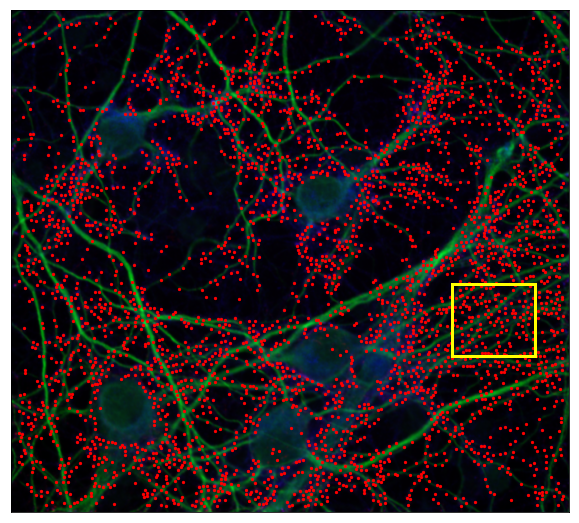

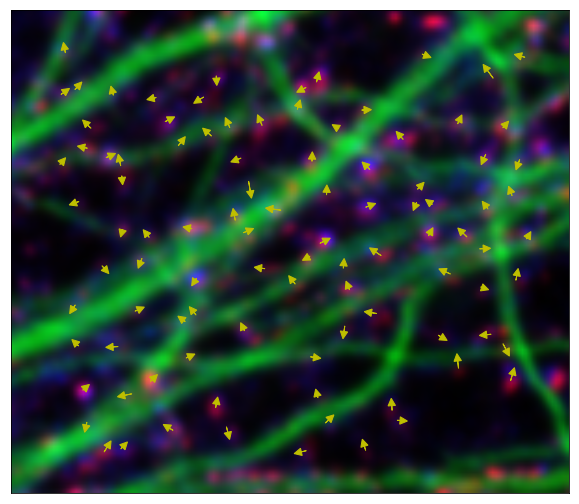

In [27]:
plot_img = np.dstack([rep31.data[0,req_channels.index('synapsin-1')],
                      rep31_map.data[0,0],
                     rep31.data[0,req_channels.index('PSD-95')]])

plot_img = (plot_img-np.min(plot_img,(0,1)))/(np.max(plot_img,(0,1))-np.min(plot_img,(0,1))).astype(np.float)

ax,y = draw_proccessed(rep31.data[0],plot_img)
xx,yy,_ = dognet.find_peaks(y[0,0],3)
plt.scatter(yy,xx,s=5,c='red')

x1 =490
x2 =620
y1 =790
y2 =940

rect = Rectangle((y1,x1), y2-y1, x2-x1,fill=False,
                 edgecolor="yellow",lw=3)
ax.add_artist(rect)



plot_img = np.dstack([rep31.data[0,req_channels.index('synapsin-1'),x1:x2,y1:y2],
                      rep31_map.data[0,0,x1:x2,y1:y2],
                     rep31.data[0,req_channels.index('PSD-95'),x1:x2,y1:y2]])

plot_img = (plot_img-np.min(plot_img,(0,1)))/(np.max(plot_img,(0,1))-np.min(plot_img,(0,1))).astype(np.float)
ax,y = draw_proccessed(rep31.data[0][:,x1:x2,y1:y2],plot_img)#rep31_dapi.data[0,1,x1:x2,y1:y2])
xx,yy,_ = dognet.find_peaks(y[0,0],3)

syn = dognet.extract_descriptor(rep31.data[0][req_channels.index('synapsin-1'),x1:x2,y1:y2],
                                xx,yy,window_size=5,get_gaussian=dognet.get_gaussian)
psd = dognet.extract_descriptor(rep31.data[0][req_channels.index('PSD-95'),x1:x2,y1:y2],
                                xx,yy,window_size=5,get_gaussian=dognet.get_gaussian)

for s,p in zip(syn,psd):
    ax.arrow(s[0],s[1], p[0]-s[0], p[1]-s[1], head_width=2., head_length=2., fc='y', ec='y')
    


### Export synapse descriptors as CSV file

In [118]:
for rep,name in zip([rep21,rep31],['rep21','rep31']):
    dm = []
    for fov in range(0,6):
        x = rep.data[fov]
        y = inference(net,normalize(x,get_normparams(rep21.data))) 
        xx,yy,_ = dognet.find_peaks(y[0,0],3)
        for c in range(len(req_channels)):
            
            desc = dognet.extract_descriptor(x[c],xx,yy,5)
            dm+=[[fov,req_channels[c]]+d for d in desc]
    dm = np.array(dm)            
    d = {'fov': dm[:,0] , 'marker': dm[:,1],'x': dm[:,2] ,'y': dm[:,3] ,'A': dm[:,4] ,'L1': dm[:,5]
         ,'L2': dm[:,6] ,'sigmax2': dm[:,7],'sigmay2': dm[:,8],'sigmaxy': dm[:,9],'angle': dm[:,10],
         'x_dog': dm[:,11],'y_dog': dm[:,12]}
    df = pd.DataFrame(data=d)
    df.to_csv(name+".csv")

### Benchmark vs baseline vs architectures

In [29]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format


baselines = [dognet.baselines.FCN(len(req_channels),4,3),
            dognet.baselines.FCN(len(req_channels),2,2),
            dognet.baselines.Unet(len(req_channels),1,y=1),
            dognet.baselines.Unet(len(req_channels),1,y=3)]

deepdogs = [
            dognet.DeepAnisotropic(len(req_channels),9,4,3,learn_amplitude=False),
            dognet.DeepIsotropic(len(req_channels),11,4,3,learn_amplitude=False),  
            dognet.SimpleAnisotropic(len(req_channels),11,12,learn_amplitude=False),
            dognet.SimpleIsotropic(len(req_channels),11,12,learn_amplitude=False)
            ]

dogs = [
            dognet.DeepAnisotropic(len(req_channels),11,4,2,learn_amplitude=False),
            dognet.DeepIsotropic(len(req_channels),11,4,2,learn_amplitude=False),  
            dognet.SimpleAnisotropic(len(req_channels),11,4,learn_amplitude=False),
            dognet.SimpleIsotropic(len(req_channels),11,4,learn_amplitude=False)
            ]


            
def run_benchmark(networks,name,gen):
    result = []
    for n in networks:
        reset_net(n)
        net,errors =dognet.train_routine(n.cuda(),gen,n_iter=3000,margin=5)
        result.append([net.__class__,dognet.get_n_params(net)]+list(estimate(net,rep31_anno)))
    df = pd.DataFrame(result)
    df.columns = ['name','#','f1','precision','recall']
    df.to_csv('prism_results_'+name+'.csv')
    print(df)
    



In [30]:
def get_random(repos,size,margin):
    xxx = []
    yyy = []
    pts = []
    nsamples = np.random.randint(1,len(repos))
    for n in range(nsamples):
        rep_id = np.random.randint(0,len(repos))
        xx = (np.random.randint(0,repos[rep_id].image.shape[1]-size[0]))
        yy = (np.random.randint(0,repos[rep_id].image.shape[2]-size[1]))

        xxx.append(normalize(repos[rep_id].image[:,int(xx):int(xx+size[0]),int(yy):int(yy+size[1])],get_normparams(rep21.data)))
        yyy.append(repos[rep_id].labels[int(xx):int(xx+size[0]),int(yy):int(yy+size[1])])
        pts.append(np.array([[x-yy,y-xx] for x,y in zip(repos[rep_id].x,repos[rep_id].y) if 
                             (x>yy+margin and x<yy+size[1]-margin and y>xx+margin and y<xx+size[0]-margin)]))
    return xxx, yyy, pts
    
def reset_net(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.normal_(0., 2.5)
            
def trials(nets,sz,nrep,anno):
    result = []
    for s in sz:
        print('size:',s)
        for i in range(nrep):

            x,y,pt = get_random(anno,(s,s),5)
            
            
            gen = dognet.create_generator(x,y,size=(64,64))
            for n in nets:
                #reset_net(n)
                #n = dognet.SimpleIsotropic(len(req_channels),11,4,learn_amplitude=False)
                n.weights_init()
                               
                n,errors =dognet.train_routine(n.cuda(),gen,n_iter=3000,margin=5,verbose=False)                    
                f1,pre,re = estimate(n,rep31_anno)
                result.append([n.__class__,dognet.get_n_params(n),np.concatenate(pt).shape[0]]+list([f1,pre,re]))
                print(i,' n ex: ',np.concatenate(pt).shape[0],f1)
               
            
                
    df = pd.DataFrame(result)
    df.columns = ['name','#','# ex','f1','precision','recall']
    df.to_csv('prism_results_examples_ex_matt.csv')
    print(df)
    

In [31]:
def examples_benchmark(networks,repos,sizes,name,norm_params = get_normparams(rep21.data)):
     
    result = []
    for s in sizes:
        data =[]
        labels = []
        examples = 0
        for r in repos[:s[2]]:
            print(r.image.shape,s)
            xbeg = r.image.shape[1]/2-s[0]/2
            xend = r.image.shape[1]/2+s[0]/2
            ybeg = r.image.shape[2]/2-s[1]/2
            yend = r.image.shape[2]/2+s[1]/2
            data.append(normalize(r.image,norm_params)[:,
                                                       xbeg:xend,
                                                       ybeg:yend])
            labels.append(r.labels[xbeg:xend,
                                   ybeg:yend])
            pts = np.array([[x-ybeg,y-xbeg] for x,y in zip(r.x,r.y) if (x>ybeg and x<yend-1 and y>xbeg and y<xend-1)])
            examples += pts.shape[0]
        
        
        print(examples)
        gen = dognet.create_generator( data,labels)
        for n in networks:
            net,errors =dognet.train_routine(n.cuda(),gen,n_iter=3000,margin=3)
            result.append([net.__class__,dognet.get_n_params(net),examples]+list(estimate(net,rep31_anno)))
            
    df = pd.DataFrame(result)
    df.columns = ['name','#','# ex','f1','precision','recall']
    df.to_csv('prism_results_examples'+name+'.csv')
    print(df)
           